In [61]:
import pandas as pd
import numpy as np
import altair as alt
alt.data_transformers.enable('json')

import matplotlib.pyplot as plt

from metpy.calc import add_height_to_pressure
from metpy.units import units
import sys
sys.path.append('../splash/')
import functions_library

# Open SOS Measurement Dataset

In [62]:
start_date = '20221130'
end_date = '20230509'
# open files
tidy_df_5Min = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
tidy_df_30Min = pd.read_parquet(f'tidy_df_30min_{start_date}_{end_date}_noplanar_fit_clean.parquet')
# convert time column to datetime
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df_5Min = tidy_df_5Min.set_index('time').sort_index().loc[start_date:end_date].reset_index()

# Open Turbpy Model Ensemble Dataset

In [63]:
model_df = pd.read_parquet("model_results.parquet")
# add a bunch of columns that are descriptive, from the config column which has multiple bits of info
model_df['z0'] = model_df['config'].apply(
    lambda v: v.split(' ')[-1]
)
model_df['e_sat_curve'] = model_df['config'].apply(
    lambda v: 'metpy' if 'metpy' in v else 'alduchov'
)
model_df['surface_measurement'] = model_df['config'].apply(
    lambda v: v.split(' ')[-3]
)
model_df['scheme'] = model_df['config'].apply(
    lambda v: 'andreas' if 'andreas lengths' in v else 'yang'
)
model_df['most_config'] = model_df['config'].apply(lambda s: ' '.join(s.split(' ')[:-3]))
# remove the scalar roughness length parameterization info 
model_df['most_config'] = model_df['most_config'].str.replace(' andreas lengths', '')

model_df['time'] = model_df['time'].dt.tz_localize('US/Mountain')
model_df.head()

,time,config,latent heat flux,sensible heat flux,zeta,latent heat conductance,sensible heat conductance,z0,e_sat_curve,surface_measurement,scheme,most_config
0,2022-11-30 00:00:00-07:00,Standard Tsurf_c e_sat_alduchov z0_andreas,0.000953,-0.038413,NaN,0.025557,0.025557,z0_andreas,alduchov,Tsurf_c,yang,Standard
1,2022-11-30 00:30:00-07:00,Standard Tsurf_c e_sat_alduchov z0_andreas,0.002109,-0.067827,NaN,0.046624,0.046624,z0_andreas,alduchov,Tsurf_c,yang,Standard
2,2022-11-30 01:00:00-07:00,Standard Tsurf_c e_sat_alduchov z0_andreas,0.002728,-0.024059,NaN,0.029151,0.029151,z0_andreas,alduchov,Tsurf_c,yang,Standard
3,2022-11-30 01:30:00-07:00,Standard Tsurf_c e_sat_alduchov z0_andreas,0.000492,-0.006442,NaN,0.006415,0.006415,z0_andreas,alduchov,Tsurf_c,yang,Standard
4,2022-11-30 02:00:00-07:00,Standard Tsurf_c e_sat_alduchov z0_andreas,0.000169,-0.057172,NaN,0.030208,0.030208,z0_andreas,alduchov,Tsurf_c,yang,Standard


### Handle a pesky outlier

This outlier is because of a messed up Tsurf_d value that we need to filter

In [64]:
model_df.loc[(model_df.time == "2023-01-22 1400") & (model_df.surface_measurement == 'Tsurf_d'), 'latent heat flux'] = 0
model_df.loc[(model_df.time == "2023-01-22 1400") & (model_df.surface_measurement == 'Tsurf_d'), 'sensible heat flux'] = 0

# Open COARE model results

In [65]:
coare_model_results = pd.read_parquet("coare_model_results.parquet").reset_index()
coare_model_results['z0'] = coare_model_results.config.str.split(' ').apply(lambda x: x[-1])
coare_model_results['surface_measurement'] = coare_model_results.config.str.split(' ').apply(lambda x: x[0])
coare_model_results['e_sat_curve'] = coare_model_results.config.str.split(' ').apply(lambda x: x[1])
coare_model_results.head(3)

coare_model_results.loc[(coare_model_results.time == "2023-01-22 1400") & (coare_model_results.surface_measurement == 'Tsurf_d'), 'hlb_gperm2s'] = 0
coare_model_results.loc[(coare_model_results.time == "2023-01-22 1400") & (coare_model_results.surface_measurement == 'Tsurf_d'), 'hsb'] = 0

# Calculate model run seasonal totals

In [66]:
from metpy.constants import density_water
seconds_in_sos_timestep = 60*30

## COARE model runs

In [67]:
coare_model_results['hlb_mm'] = coare_model_results['hlb_gperm2s']*seconds_in_sos_timestep/density_water
coare_cumsum_model_results = pd.DataFrame(coare_model_results.reset_index().sort_values("time").set_index(
    ["time", "config", "z0", "surface_measurement", "e_sat_curve"]
).groupby(["config"])['hlb_mm'].cumsum()).reset_index()
coare_cumsum_model_results

,time,config,z0,surface_measurement,e_sat_curve,hlb_mm
0,2022-11-30 00:00:00,Tsurf_c e_sat_alduchov z0_andreas,z0_andreas,Tsurf_c,e_sat_alduchov,0.000425
1,2022-11-30 00:00:00,Tsurf_rad_d e_sat_alduchov 0.005,0.005,Tsurf_rad_d,e_sat_alduchov,-0.002738
2,2022-11-30 00:00:00,Tsurf_rad_d e_sat_alduchov z0_andreas_weekly,z0_andreas_weekly,Tsurf_rad_d,e_sat_alduchov,-0.002332
3,2022-11-30 00:00:00,Tsurf_d e_sat_alduchov 0.001,0.001,Tsurf_d,e_sat_alduchov,-0.002173
4,2022-11-30 00:00:00,Tsurf_c e_sat_alduchov 0.001,0.001,Tsurf_c,e_sat_alduchov,0.000382
...,...,...,...,...,...,...
208273,2023-05-09 17:30:00,Tsurf_d e_sat_alduchov 0.0005,0.0005,Tsurf_d,e_sat_alduchov,46.901452
208274,2023-05-09 17:30:00,Tsurf_c e_sat_alduchov z0_windprofile_weekly,z0_windprofile_weekly,Tsurf_c,e_sat_alduchov,56.513281
208275,2023-05-09 17:30:00,Tsurf_c e_sat_alduchov 0.0005,0.0005,Tsurf_c,e_sat_alduchov,49.722774
208276,2023-05-09 17:30:00,Tsurf_rad_d e_sat_alduchov 0.0001,0.0001,Tsurf_rad_d,e_sat_alduchov,57.383643


In [68]:
coare_seasonal_model_results = pd.DataFrame(coare_cumsum_model_results.groupby([
    "config", 
    "z0",
    'surface_measurement',
    'e_sat_curve'
])['hlb_mm'].max()).reset_index()
coare_seasonal_model_results.head()

,config,z0,surface_measurement,e_sat_curve,hlb_mm
0,Tsurf_c e_sat_alduchov 0.0001,0.0001,Tsurf_c,e_sat_alduchov,41.105549
1,Tsurf_c e_sat_alduchov 0.0005,0.0005,Tsurf_c,e_sat_alduchov,49.722774
2,Tsurf_c e_sat_alduchov 0.001,0.001,Tsurf_c,e_sat_alduchov,52.576662
3,Tsurf_c e_sat_alduchov 0.005,0.005,Tsurf_c,e_sat_alduchov,57.234686
4,Tsurf_c e_sat_alduchov 1e-05,1e-05,Tsurf_c,e_sat_alduchov,29.934171


## for TurbPy model runs

In [69]:
model_df_cumsum = pd.DataFrame(model_df.sort_values("time").set_index(
    ["time", "config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"]
).groupby(["config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"])['latent heat flux'].cumsum()).reset_index()
agg_model_df = model_df.set_index('time').sort_index().loc[ : '20230509 17:30:0'].reset_index()
agg_model_df = agg_model_df[[
    'time',
    'config',
    'most_config',
    'z0',
    'e_sat_curve',
    'surface_measurement',
    'scheme',
    'latent heat flux'
]]
agg_model_df['latent heat flux (mm)'] = agg_model_df['latent heat flux']*seconds_in_sos_timestep/density_water
agg_model_cum_df = pd.DataFrame(agg_model_df.sort_values("time").set_index(
    ["time", "config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"]
).groupby(["config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"])['latent heat flux (mm)'].cumsum()).reset_index()
agg_model_cum_df = agg_model_cum_df[agg_model_cum_df.time == agg_model_cum_df.time.max()]
agg_model_cum_df['complexity'] = agg_model_cum_df.most_config.isin(['Standard','Louis b = 12']).apply(lambda is_not_complex: 'bulk' if is_not_complex else 'most')

In [71]:
measured_value = tidy_df_30Min.query("variable == 'w_h2o__3m_c'").set_index('time')[['value']].cumsum().max().value*seconds_in_sos_timestep/density_water.magnitude
measured_min_value = tidy_df_30Min.query("variable == 'w_h2o__15m_c'").set_index('time')[['value']].cumsum().max().value*seconds_in_sos_timestep/density_water.magnitude
measured_max_value = tidy_df_30Min.query("variable == 'w_h2o__10m_uw'").set_index('time')[['value']].cumsum().max().value*seconds_in_sos_timestep/density_water.magnitude

In [72]:
measured_value, measured_min_value, measured_max_value

(33.922023193961024, 28.670403384122164, 39.171424445718515)

# Isolate model runs we care about

## COARE


In [109]:
coare_cumsum_model_results = pd.DataFrame(coare_model_results.reset_index().sort_values("time").set_index(
    ["time", "config"]
).groupby(["config"])['hlb_mm'].cumsum()).reset_index()
coare_cumsum_model_results['z0'] = coare_cumsum_model_results.config.str.split(' ').apply(lambda x: x[-1])
coare_cumsum_model_results['surface_measurement'] = coare_cumsum_model_results.config.str.split(' ').apply(lambda x: x[0])
coare_cumsum_model_results['e_sat_curve'] = coare_cumsum_model_results.config.str.split(' ').apply(lambda x: x[1])
coare_cumsum_model_results

coare_seasonal_model_results = pd.DataFrame(coare_cumsum_model_results.groupby([
    "config", 
    "z0",
    'surface_measurement',
    'e_sat_curve'
])['hlb_mm'].max()).reset_index()

coare_seasonal_model_results = coare_seasonal_model_results[coare_seasonal_model_results.z0 != 'z0_windprofile_weekly']

## Turbpy

In [110]:
# MOST runs
src = agg_model_cum_df.query("e_sat_curve == 'alduchov'").query("complexity == 'most'").query("scheme == 'andreas'")
src = src[src.z0 != 'z0_windprofile_weekly']

# Standard bulk aerodynamic
src_standard = agg_model_cum_df[agg_model_cum_df.most_config == 'Standard']
src_standard = src_standard[src_standard.z0 != 'z0_windprofile_weekly']

# Plot Modeled Seasonal Totals, TurbPy and COARE, constant and variable z0 values

In [111]:
# Create horizontal rules for measured values
rules = alt.Chart().transform_calculate(
    measured = str(measured_value)
).mark_rule(strokeDash=[3,4], color='grey', opacity=0.25).encode(
    y='measured:Q'
) + alt.Chart().transform_calculate(
    measured = str(measured_min_value)
).mark_rule(strokeDash=[3,4], color='grey', opacity=0.25).encode(
    y='measured:Q'
) + alt.Chart().transform_calculate(
    measured = str(measured_max_value)
).mark_rule(strokeDash=[3,4], color='grey', opacity=0.25).encode(
    y='measured:Q'
)

In [160]:
z0_sort = ['1e-05', '5e-05', '0.0001', '0.0005', '0.001', '0.005', 
'z0_andreas', 'z0_windprofile_weekly', 'z0_andreas_weekly']

turbpy_model_results_chart = rules + (alt.Chart(src).mark_tick().encode(
    alt.X("z0:O").sort(z0_sort).axis(labelAngle=-45),
    alt.Y("latent heat flux (mm):Q").scale(zero=False),
    alt.Color("surface_measurement:N").title("Tₛ Sensor"),
    detail='config:N'
)
).properties(width = 300, height = 200, title='SNTHERM Algorithm (ticks) and Bulk Aerodynamic (dots)')

turbpy_model_results_chart

alt.LayerChart(...)

In [161]:
z0_sort = ['1e-05', '5e-05', '0.0001', '0.0005', '0.001', '0.005', 
'z0_andreas', 'z0_windprofile_weekly', 'z0_andreas_weekly']

turbpy_model_results_chart_standard = rules + (alt.Chart(src_standard).mark_circle().encode(
    alt.X("z0:O").sort(z0_sort).axis(labelAngle=-45),
    alt.Y("latent heat flux (mm):Q").scale(zero=False, domain=[20,140], clamp=True).title("Cumulative sublimation (mm)"),
    alt.Color("surface_measurement:N").title("Tₛ Sensor"),
    detail='config:N'
)
).properties(width = 300, height = 200, title='SNTHERM Algorithm')

turbpy_model_results_chart_standard

alt.LayerChart(...)

In [162]:
turbpy_model_results_chart + turbpy_model_results_chart_standard

alt.LayerChart(...)

In [163]:
coare_model_results_chart = rules + (
alt.Chart(coare_seasonal_model_results).mark_tick(
).encode(
    alt.X("z0:O").sort(z0_sort).axis(labelAngle=-45),
    alt.Y("hlb_mm:Q").scale(zero=False).title("Cumulative sublimation (mm)"),
    alt.Color("surface_measurement:N").title("Tₛ Sensor"),
)
).properties(width = 300, height = 200, title = 'COARE Algorithm')
coare_model_results_chart

alt.LayerChart(...)

## Combined Plot

In [165]:
(
    (
        (
            turbpy_model_results_chart + turbpy_model_results_chart_standard
        ) | coare_model_results_chart
    ).resolve_scale(y='shared')
).configure_axis(grid=False).display(renderer='svg')

alt.HConcatChart(...)

## Combined Table

In [167]:
len(src)

96

In [168]:
len(src_standard)

24

In [169]:
len(coare_seasonal_model_results)

24

In [170]:
coare_seasonal_model_results

,config,z0,surface_measurement,e_sat_curve,hlb_mm
0,Tsurf_c e_sat_alduchov 0.0001,0.0001,Tsurf_c,e_sat_alduchov,41.105549
1,Tsurf_c e_sat_alduchov 0.0005,0.0005,Tsurf_c,e_sat_alduchov,49.722774
2,Tsurf_c e_sat_alduchov 0.001,0.001,Tsurf_c,e_sat_alduchov,52.576662
3,Tsurf_c e_sat_alduchov 0.005,0.005,Tsurf_c,e_sat_alduchov,57.234686
4,Tsurf_c e_sat_alduchov 1e-05,1e-05,Tsurf_c,e_sat_alduchov,29.934171
5,Tsurf_c e_sat_alduchov 5e-05,5e-05,Tsurf_c,e_sat_alduchov,37.457623
6,Tsurf_c e_sat_alduchov z0_andreas,z0_andreas,Tsurf_c,e_sat_alduchov,52.396380
7,Tsurf_c e_sat_alduchov z0_andreas_weekly,z0_andreas_weekly,Tsurf_c,e_sat_alduchov,42.238061
9,Tsurf_d e_sat_alduchov 0.0001,0.0001,Tsurf_d,e_sat_alduchov,38.679133
10,Tsurf_d e_sat_alduchov 0.0005,0.0005,Tsurf_d,e_sat_alduchov,46.901452


# Combine our 3 sources of information (measured data, turbpy models, COARE models) and compare with Stossel box data

In [156]:
# COARE
coare_model_results
# TURBPY
model_results_for_stossel_comparison = model_df.query("e_sat_curve == 'alduchov'").query("scheme == 'andreas'").query("surface_measurement == 'Tsurf_c'").query("most_config == 'MO Holtslag de Bruin'")
model_results_for_stossel_comparison = model_results_for_stossel_comparison[['time', 'latent heat flux', 'z0']]
model_results_for_stossel_comparison = model_results_for_stossel_comparison.set_index('time').tz_localize(None).reset_index()

# MEASUREMENTS
measurements_for_stossel_comparison = tidy_df_30Min.query("variable == 'w_h2o__3m_c'").set_index('time')[['value']].rename(columns={'value': 'measured'})

In [157]:
lysimeter_data = pd.read_csv("../sos/processed_lysimeter_data.csv")
lysimeter_data['time'] = pd.to_datetime(lysimeter_data['time'])
lysimeter_data['time_previous'] = pd.to_datetime(lysimeter_data['time_previous'])
lysimeter_data.head()

,Unnamed: 0,time_previous,time,delta_box_mean_mm,daytime
0,8,2023-02-03 16:26:00,2023-02-04 07:55:00,0.021063,False
1,9,2023-02-04 07:55:00,2023-02-04 16:30:00,-0.048646,True
2,10,2023-02-04 16:30:00,2023-02-05 08:02:00,0.013541,False
3,13,2023-02-07 12:28:00,2023-02-07 17:28:00,-0.044634,True
4,15,2023-02-09 17:00:00,2023-02-10 08:00:00,0.015547,False


In [158]:
combined_results_df = pd.DataFrame()
for i, row in lysimeter_data.iterrows():
    tprev = row['time_previous']
    t = row['time'] 
    
    # collect coare data
    this_coare_data = coare_model_results.set_index('time').sort_index().loc[tprev: t].pivot_table(
        index='time',
        values=['hlb_gperm2s'],
        columns='z0'
    )
    this_coare_data.columns = ['coare (z0=' + col + ')' for col in this_coare_data.columns.get_level_values(1)]
    this_coare_data = this_coare_data.sum()
    
    # collect turbpy data
    this_turbpy_data = model_results_for_stossel_comparison.set_index('time').sort_index().loc[tprev: t].pivot_table(
            index='time',
            values=['latent heat flux'],
            columns='z0'
    )
    this_turbpy_data.columns = ['turbpy (z0=' + col + ')' for col in this_turbpy_data.columns.get_level_values(1)]
    this_turbpy_data = this_turbpy_data.sum()

    # measured data
    this_ec_data = measurements_for_stossel_comparison.loc[tprev: t].sum()

    this_measurement_df = pd.DataFrame(pd.concat([
        this_coare_data,
        this_turbpy_data,
        this_ec_data.rename({'measured': 'EC measured'}),
        # make this negative to match the other stuff
        - row[['delta_box_mean_mm']].rename({'delta_box_mean_mm': 'Lysimeter measured'})
    ])).reset_index().rename(columns={
        0: 'lh flux (mm)',
        'index': 'measurement'
    })
    this_measurement_df['time'] = row['time']
    this_measurement_df['time_previous'] = row['time_previous']
    this_measurement_df['daytime'] = row['daytime']
    combined_results_df = pd.concat([combined_results_df, this_measurement_df])

Make the "lost mass" measurements from the stossel box positive

In [21]:
combined_results_df['type'] = combined_results_df['measurement'].apply(lambda s: s.split(' ')[0])
combined_results_df

,measurement,lh flux (mm),time,time_previous,daytime,type
0,coare (z0=0.0001),-0.005522,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
1,coare (z0=0.0005),-0.006939,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
2,coare (z0=0.001),-0.00794,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
3,coare (z0=0.005),-0.01243,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
4,coare (z0=1e-05),-0.004316,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
...,...,...,...,...,...,...
15,turbpy (z0=z0_andreas),-0.0849,2023-02-18 08:10:00,2023-02-17 17:05:00,False,turbpy
16,turbpy (z0=z0_andreas_weekly),-0.075152,2023-02-18 08:10:00,2023-02-17 17:05:00,False,turbpy
17,turbpy (z0=z0_windprofile_weekly),-0.042566,2023-02-18 08:10:00,2023-02-17 17:05:00,False,turbpy
18,EC measured,-0.017162,2023-02-18 08:10:00,2023-02-17 17:05:00,False,EC


In [22]:
combined_results_df

,measurement,lh flux (mm),time,time_previous,daytime,type
0,coare (z0=0.0001),-0.005522,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
1,coare (z0=0.0005),-0.006939,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
2,coare (z0=0.001),-0.00794,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
3,coare (z0=0.005),-0.01243,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
4,coare (z0=1e-05),-0.004316,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
...,...,...,...,...,...,...
15,turbpy (z0=z0_andreas),-0.0849,2023-02-18 08:10:00,2023-02-17 17:05:00,False,turbpy
16,turbpy (z0=z0_andreas_weekly),-0.075152,2023-02-18 08:10:00,2023-02-17 17:05:00,False,turbpy
17,turbpy (z0=z0_windprofile_weekly),-0.042566,2023-02-18 08:10:00,2023-02-17 17:05:00,False,turbpy
18,EC measured,-0.017162,2023-02-18 08:10:00,2023-02-17 17:05:00,False,EC


In [23]:
(alt.Chart(combined_results_df.query("daytime == True")).mark_tick().encode(
    alt.X("type:N"),
    alt.Y("lh flux (mm)"),
    alt.Column('time:T'),
).properties(height = 100) & alt.Chart(combined_results_df.query("daytime == False")).mark_tick().encode(
    alt.X("type:N"),
    alt.Y("lh flux (mm)"),
    alt.Column('time:T'),
).properties(height = 100)).display(renderer='svg')

alt.VConcatChart(...)

## plot wind speeds, lh flux profiles, theta_v profiles, to see if on Feb 7, 11, 12, advection is likely, while on Feb 4, 10, 17 it seems less likely

In [24]:
case_studies_advective = pd.concat([
    tidy_df_30Min.set_index('time').loc['20230207': '20230207'],
    tidy_df_30Min.set_index('time').loc['20230211': '20230212']
])
case_studies_advective['day'] = case_studies_advective.index.day

case_studies_normal = pd.concat([
    tidy_df_30Min.set_index('time').loc['20230204': '20230204'],
    tidy_df_30Min.set_index('time').loc['20230210': '20230210'],
    tidy_df_30Min.set_index('time').loc['20230217': '20230217']
])

case_studies_normal['day'] = case_studies_normal.index.day

In [25]:
winddir_chart = alt.Chart(
    case_studies_advective.query("measurement == 'wind direction'").reset_index()
).transform_filter(
    alt.datum.tower == 'c'
).transform_filter(
    alt.FieldOneOfPredicate('height', [3,10,20])
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:O"),
    alt.Column("day:O")
).properties(width=200, height = 200).resolve_scale(x='independent')

bsflux_chart = alt.Chart(
    case_studies_advective.query("measurement == 'snow flux'").reset_index().query("value > 0")
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(type='log'),
    alt.Color("height:O"),
    alt.Column("day:O")
).properties(width=200, height = 50).resolve_scale(x='independent')

profiles_src = case_studies_advective.query("measurement == 'w_h2o_'").query("tower == 'c'").reset_index()
profiles_src = profiles_src.set_index("time").groupby([
    pd.Grouper(freq='240Min'), 'height', 'day'
]).mean(numeric_only=True).reset_index()
profiles_src['hour'] = profiles_src.time.dt.hour

lhflux_profiles_chart = alt.Chart(
    profiles_src    
).mark_line().encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height:Q"),
    alt.Color("hour:O").scale(scheme='rainbow'),
    alt.Column("day:O")
).resolve_scale(color='shared').properties(width=200, height = 200)

profiles_src = case_studies_advective.query("measurement == 'potential virtual temperature'").query("tower == 'c'").reset_index()
profiles_src = profiles_src.set_index("time").groupby([
    pd.Grouper(freq='240Min'), 'height', 'day'
]).mean(numeric_only=True).reset_index()
profiles_src['hour'] = profiles_src.time.dt.hour

thetav_profiles_chart = alt.Chart(
    profiles_src    
).mark_line().encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height:Q"),
    alt.Color("hour:O").scale(scheme='rainbow'),
    alt.Column("day:O")
).resolve_scale(color='shared').properties(width=200, height = 200)

(bsflux_chart & winddir_chart & lhflux_profiles_chart & thetav_profiles_chart).resolve_scale(color='independent')

alt.VConcatChart(...)

In [26]:
winddir_chart = alt.Chart(
    case_studies_normal.query("measurement == 'wind direction'").reset_index()
).transform_filter(
    alt.datum.tower == 'c'
).transform_filter(
    alt.FieldOneOfPredicate('height', [3,10,20])
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:O"),
    alt.Column("day:O")
).properties(width=200, height = 200).resolve_scale(x='independent')

bsflux_chart = alt.Chart(
    case_studies_normal.query("measurement == 'snow flux'").reset_index().query("value > 0")
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(type='log'),
    alt.Color("height:O"),
    alt.Column("day:O")
).properties(width=200, height = 50).resolve_scale(x='independent')

profiles_src = case_studies_normal.query("measurement == 'w_h2o_'").query("tower == 'c'").reset_index()
profiles_src = profiles_src.set_index("time").groupby([
    pd.Grouper(freq='240Min'), 'height', 'day'
]).mean(numeric_only=True).reset_index()
profiles_src['hour'] = profiles_src.time.dt.hour

lhflux_profiles_chart = alt.Chart(
    profiles_src    
).mark_line().encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height:Q"),
    alt.Color("hour:O").scale(scheme='rainbow'),
    alt.Column("day:O")
).resolve_scale(color='shared').properties(width=200, height = 200)

profiles_src = case_studies_normal.query("measurement == 'potential virtual temperature'").query("tower == 'c'").reset_index()
profiles_src = profiles_src.set_index("time").groupby([
    pd.Grouper(freq='240Min'), 'height', 'day'
]).mean(numeric_only=True).reset_index()
profiles_src['hour'] = profiles_src.time.dt.hour

thetav_profiles_chart = alt.Chart(
    profiles_src    
).mark_line().encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height:Q"),
    alt.Color("hour:O").scale(scheme='rainbow'),
    alt.Column("day:O")
).resolve_scale(color='shared').properties(width=200, height = 200)

(bsflux_chart & winddir_chart & lhflux_profiles_chart & thetav_profiles_chart).resolve_scale(color='independent')

alt.VConcatChart(...)

# Look at some time series of the combined results

In [27]:
alt.Chart(
    model_results_for_stossel_comparison.set_index('time').sort_index().loc['20230401': '20230415'].reset_index()
).mark_line(opacity=0.25, color='orange').encode(
    alt.X("time:T"),
    alt.Y("latent heat flux:Q"),
    detail = 'z0'
).properties(width = 1000) + alt.Chart(
    measurements_for_stossel_comparison.sort_index().loc['20230401': '20230415'].reset_index()
).mark_circle(color='black').encode(
    alt.X("time:T"),
    alt.Y("measured:Q"),
).properties(width = 1000)

alt.LayerChart(...)

In [28]:
alt.Chart(
    coare_model_results.set_index('time').sort_index().loc['20230401': '20230415'].reset_index()
).mark_line(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("hlb_gperm2s:Q"),
    detail = 'z0'
).properties(width = 1000) + alt.Chart(
    measurements_for_stossel_comparison.sort_index().loc['20230401': '20230415'].reset_index()
).mark_circle(color='black').encode(
    alt.X("time:T"),
    alt.Y("measured:Q"),
).properties(width = 1000)

alt.LayerChart(...)

In [29]:
alt.Chart(
    coare_model_results.set_index('time').sort_index().loc['20230201': '20230215'].reset_index()
).mark_line(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("hlb_gperm2s:Q"),
    detail = 'z0'
).properties(width = 1000) + alt.Chart(
    measurements_for_stossel_comparison.sort_index().loc['20230201': '20230215'].reset_index()
).mark_circle(color='black').encode(
    alt.X("time:T"),
    alt.Y("measured:Q"),
).properties(width = 1000)

alt.LayerChart(...)

In [30]:
coare_model_results.z0.unique()

array(['z0_andreas', 'z0_andreas_weekly', 'z0_windprofile_weekly',
       '1e-05', '5e-05', '0.0001', '0.0005', '0.001', '0.005'],
      dtype=object)

In [31]:
alt.Chart(
    coare_model_results.set_index('time').sort_index().loc['20230315': '20230330'].reset_index()
).transform_filter(
    alt.datum.z0 == '0.00001'
).mark_line(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("hlb_gperm2s:Q"),
    detail = 'z0'
).properties(width = 1000) + alt.Chart(
    measurements_for_stossel_comparison.sort_index().loc['20230315': '20230330'].reset_index()
).mark_circle(color='black').encode(
    alt.X("time:T"),
    alt.Y("measured:Q"),
).properties(width = 1000)

alt.LayerChart(...)

# Calculate statistics

## Create dataset, combining measured data with model results from different sources  

Use a subset of TurbPy results, all the COARE results, and measured data at 3m on tower c, the tower and height of measurements used to run the models

### Turbpy models

In [32]:
select_turbpy_results_df = model_df[
    model_df['config'].isin([
        'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov 1e-05',
        'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov 0.0001',
        'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov 0.0005',
        'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov z0_andreas',
        'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov z0_andreas_weekly',
    ]) 
]
select_turbpy_results_df['z0'] = select_turbpy_results_df['z0'].astype('str')
select_turbpy_results_df = select_turbpy_results_df[['time', 'z0', 'latent heat flux']].pivot_table(
    index='time', columns='z0',
)
select_turbpy_results_df.columns = select_turbpy_results_df.columns.to_flat_index().str.join('_')
select_turbpy_results_df = select_turbpy_results_df.loc[:'2023-05-09']
select_turbpy_results_df.columns = select_turbpy_results_df.columns.to_series().apply(lambda s: f"turbpy (z0 = {s.split('_')[-1]})").values

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_31749/1921770608.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_turbpy_results_df['z0'] = select_turbpy_results_df['z0'].astype('str')


### NOAA/COARE Models

### Measured data

In [33]:
measured_df = tidy_df_30Min.query("variable == 'w_h2o__3m_c'").set_index('time')[['value']].rename(columns={'value': 'measured'})

### Combine it all

In [34]:
select_turbpy_results_df = select_turbpy_results_df.reset_index('time')
select_turbpy_results_df['time'] = select_turbpy_results_df['time'].dt.tz_localize(None)
select_turbpy_results_df = select_turbpy_results_df.set_index('time')

select_coare_results_df = coare_model_results[['time', 'config', 'hlb_mm']].pivot(index='time', columns='config')
select_coare_results_df.columns = select_coare_results_df.columns.droplevel(0)
select_coare_results_df = select_coare_results_df[[
    "Tsurf_c e_sat_alduchov 0.0001",
    "Tsurf_c e_sat_alduchov 0.0005",
    "Tsurf_c e_sat_alduchov 1e-05",
    "Tsurf_c e_sat_alduchov z0_andreas",	
    "Tsurf_c e_sat_alduchov z0_andreas_weekly"
]].rename(columns = {
    "Tsurf_c e_sat_alduchov 0.0001": "coare (z0 = 0.0001)",
    "Tsurf_c e_sat_alduchov 0.0005": "coare (z0 = 0.0005)",
    "Tsurf_c e_sat_alduchov 1e-05": "coare (z0 = 1e-05)",
    "Tsurf_c e_sat_alduchov z0_andreas": "coare (z0=z0_andreas)",
    "Tsurf_c e_sat_alduchov z0_andreas_weekly": "coare (z0=z0_andreas_weekly)",
})

model_meas_df = measured_df.join(
    select_turbpy_results_df
).join(
    select_coare_results_df
)
model_meas_nonans_df = model_meas_df.dropna()
model_meas_nonans_df

,measured,turbpy (z0 = 0.0001),turbpy (z0 = 0.0005),turbpy (z0 = 1e-05),turbpy (z0 = andreas),turbpy (z0 = weekly),coare (z0 = 0.0001),coare (z0 = 0.0005),coare (z0 = 1e-05),coare (z0=z0_andreas),coare (z0=z0_andreas_weekly)
time,,,,,,,,,,,
2022-11-30 00:00:00,-0.001787,0.000193,0.000233,0.000142,0.000287,0.000255,0.000296,0.000361,0.000217,0.000425,0.000399
2022-11-30 00:30:00,-0.000391,0.000135,0.000171,0.000096,0.000279,0.000194,0.000147,0.000190,0.000103,0.000309,0.000228
2022-11-30 01:00:00,-0.000274,0.000272,0.000340,0.000192,0.000503,0.000385,0.000293,0.000373,0.000205,0.000540,0.000435
2022-11-30 01:30:00,-0.000585,0.000276,0.000341,0.000198,0.000376,0.000381,0.000355,0.000440,0.000255,0.000438,0.000494
2022-11-30 02:00:00,-0.000451,0.000020,0.000025,0.000014,0.000035,0.000028,0.000020,0.000026,0.000014,0.000050,0.000033
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-09 15:30:00,0.007196,0.015018,0.019535,0.010497,0.032649,0.007950,0.010167,0.013590,0.007193,0.027687,0.005596
2023-05-09 16:00:00,0.016461,0.017072,0.022033,0.012005,0.027610,0.009061,0.016906,0.022024,0.011966,0.024819,0.009091
2023-05-09 16:30:00,0.007976,0.005654,0.007517,0.004033,0.008745,0.003169,0.004443,0.005846,0.003285,0.004847,0.002666


## Do statistics calculations
1. Mean Absolute Error
2. Mean Relative Error
3. R^2
4. NSE


In [35]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
# define a function for Nash Sutcliffe
def nse(targets, predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))

In [36]:
def get_stats_df(df, data_desc):
    return pd.DataFrame([
            [data_desc, 'ME', "turbpy (z0 = 0.0001)", (df["turbpy (z0 = 0.0001)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "turbpy (z0 = 0.0005)", (df["turbpy (z0 = 0.0005)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "turbpy (z0 = 1e-05)", (df["turbpy (z0 = 1e-05)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "coare (z0 = 0.0001)", (df["coare (z0 = 0.0001)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "coare (z0 = 0.0005)", (df["coare (z0 = 0.0005)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "coare (z0 = 1e-05)", (df["coare (z0 = 1e-05)"] - df["measured"]).values.mean() ],

            [data_desc, 'MAE', "turbpy (z0 = 0.0001)", mean_absolute_error(df["measured"], df["turbpy (z0 = 0.0001)"])],
            [data_desc, 'MAE', "turbpy (z0 = 0.0005)", mean_absolute_error(df["measured"], df["turbpy (z0 = 0.0005)"])],
            [data_desc, 'MAE', "turbpy (z0 = 1e-05)", mean_absolute_error(df["measured"], df["turbpy (z0 = 1e-05)"])],
            [data_desc, 'MAE', "coare (z0 = 0.0001)", mean_absolute_error(df["measured"], df["coare (z0 = 0.0001)"])],
            [data_desc, 'MAE', "coare (z0 = 0.0005)", mean_absolute_error(df["measured"], df["coare (z0 = 0.0005)"])],
            [data_desc, 'MAE', "coare (z0 = 1e-05)", mean_absolute_error(df["measured"], df["coare (z0 = 1e-05)"])],

            [data_desc, 'MAPE', "turbpy (z0 = 0.0001)", mean_absolute_percentage_error(df["measured"], df["turbpy (z0 = 0.0001)"])],
            [data_desc, 'MAPE', "turbpy (z0 = 0.0005)", mean_absolute_percentage_error(df["measured"], df["turbpy (z0 = 0.0005)"])],
            [data_desc, 'MAPE', "turbpy (z0 = 1e-05)", mean_absolute_percentage_error(df["measured"], df["turbpy (z0 = 1e-05)"])],
            [data_desc, 'MAPE', "coare (z0 = 0.0001)", mean_absolute_percentage_error(df["measured"], df["coare (z0 = 0.0001)"])],
            [data_desc, 'MAPE', "coare (z0 = 0.0005)", mean_absolute_percentage_error(df["measured"], df["coare (z0 = 0.0005)"])],
            [data_desc, 'MAPE', "coare (z0 = 1e-05)", mean_absolute_percentage_error(df["measured"], df["coare (z0 = 1e-05)"])],

            [data_desc, 'r2', "turbpy (z0 = 0.0001)", r2_score(df["measured"], df["turbpy (z0 = 0.0001)"])],
            [data_desc, 'r2', "turbpy (z0 = 0.0005)", r2_score(df["measured"], df["turbpy (z0 = 0.0005)"])],
            [data_desc, 'r2', "turbpy (z0 = 1e-05)", r2_score(df["measured"], df["turbpy (z0 = 1e-05)"])],
            [data_desc, 'r2', "coare (z0 = 0.0001)", r2_score(df["measured"], df["coare (z0 = 0.0001)"])],
            [data_desc, 'r2', "coare (z0 = 0.0005)", r2_score(df["measured"], df["coare (z0 = 0.0005)"])],
            [data_desc, 'r2', "coare (z0 = 1e-05)", r2_score(df["measured"], df["coare (z0 = 1e-05)"])],

            [data_desc, 'NSE', "turbpy (z0 = 0.0001)", nse(df["measured"], df["turbpy (z0 = 0.0001)"])],
            [data_desc, 'NSE', "turbpy (z0 = 0.0005)", nse(df["measured"], df["turbpy (z0 = 0.0005)"])],
            [data_desc, 'NSE', "turbpy (z0 = 1e-05)", nse(df["measured"], df["turbpy (z0 = 1e-05)"])],
            [data_desc, 'NSE', "coare (z0 = 0.0001)", nse(df["measured"], df["coare (z0 = 0.0001)"])],
            [data_desc, 'NSE', "coare (z0 = 0.0005)", nse(df["measured"], df["coare (z0 = 0.0005)"])],
            [data_desc, 'NSE', "coare (z0 = 1e-05)", nse(df["measured"], df["coare (z0 = 1e-05)"])],
        ], 
        columns=['data desc', 'statistic', 'model', 'value']
    )

# Plot Statistical Results

### For different coupling regimes (using the decoupling metric) (following Peltola et al., 2021)

In [37]:
coupled_times = tidy_df_30Min.query("variable == 'omega_3m_c'").query(
    "value >= 0.61"
).time

decoupled_times = tidy_df_30Min.query("variable == 'omega_3m_c'").query(
    "value < 0.43"
).time

weaklycoupled_times = tidy_df_30Min.query("variable == 'omega_3m_c'").query(
    "value < 0.61 & value >= 0.43"
).time

blowing_snow_times = pd.concat([
    tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").query("value > 0").time,
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
])

clear_times = tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time[
    ~ tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time.isin(blowing_snow_times)
]

In [38]:
all_stats_df = pd.concat([
    get_stats_df(model_meas_nonans_df, data_desc='all'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)], data_desc='decoupled'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)], data_desc='weakly coupled'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)], data_desc='coupled'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)], data_desc='bs'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)], data_desc='no bs'),
])

In [39]:
print(len(model_meas_nonans_df))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]))

7011
1841
1152
3603
1630
5381


In [40]:
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'ME'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAPE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'r2'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'NSE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100)

alt.VConcatChart(...)

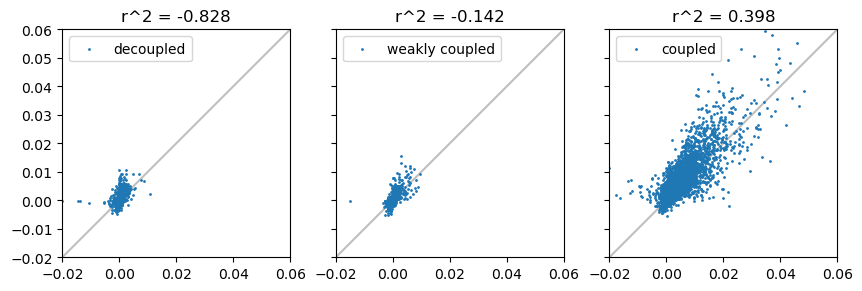

In [41]:
fig, axes = plt.subplots(1,3, figsize=(10,3), sharex=True, sharey=True)

axes[0].scatter(
    model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]['measured'],
    model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]['coare (z0 = 1e-05)'],
    s=1,
    label='decoupled'
)
axes[0].set_title(
    f"r^2 = {round(r2_score(
        model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]['measured'],
        model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]['coare (z0 = 1e-05)'],
    ), 3)}"
)
axes[1].scatter(
    model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]['measured'],
    model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]['coare (z0 = 1e-05)'],
    s=1,
    label='weakly coupled'
)
axes[1].set_title(
    f"r^2 = {round(r2_score(
        model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]['measured'],
        model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]['coare (z0 = 1e-05)'],
    ), 3)}"
)
axes[2].scatter(
    model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]['measured'],
    model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]['coare (z0 = 1e-05)'],
    s=1,
    label='coupled'
)
axes[2].set_title(
    f"r^2 = {round(r2_score(
        model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]['measured'],
        model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]['coare (z0 = 1e-05)'],
    ), 3)}"
)

for ax in axes:
    ax.plot([-0.02,0.06],[-0.02,0.06], color='grey', alpha=0.5, zorder=-1)
    ax.set_xlim(-0.02,0.06)
    ax.set_ylim(-0.02,0.06)
    ax.set_aspect('equal')
    ax.legend()

### For Different Stability Regimes (Using static stability)

In [42]:
unstable_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value < -0.01"
).time

stable_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value > 0.01"
).time

neutral_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value <= 0.01 & value >= -0.01"
).time

blowing_snow_times = pd.concat([
    tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").query("value > 0").time,
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
])

clear_times = tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time[
    ~ tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time.isin(blowing_snow_times)
]

In [43]:
all_stats_df = pd.concat([
    get_stats_df(model_meas_nonans_df, data_desc='all'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(stable_times)], data_desc='stable'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(neutral_times)], data_desc='neutral'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(unstable_times)], data_desc='unstable'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)], data_desc='bs'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)], data_desc='no bs'),
])

In [44]:
print(len(model_meas_nonans_df))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(stable_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(neutral_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(unstable_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]))

7011
6043
613
324
1630
5381


In [45]:
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'ME'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAPE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'r2'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'NSE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100)

alt.VConcatChart(...)

### For Different Stability Regimes (Using static stability, 0.1 threshold)

In [46]:
unstable_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value < -0.1"
).time

stable_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value > 0.1"
).time

neutral_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value <= 0.1 & value >= -0.1"
).time

blowing_snow_times = pd.concat([
    tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").query("value > 0").time,
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
])

clear_times = tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time[
    ~ tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time.isin(blowing_snow_times)
]

In [47]:
all_stats_df = pd.concat([
    get_stats_df(model_meas_nonans_df, data_desc='all'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(stable_times)], data_desc='stable'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(neutral_times)], data_desc='neutral'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(unstable_times)], data_desc='unstable'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)], data_desc='bs'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)], data_desc='no bs'),
])

In [48]:
print(len(model_meas_nonans_df))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(stable_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(neutral_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(unstable_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]))

7011
3400
3575
5
1630
5381


In [49]:
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAPE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'r2'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'NSE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100)

alt.VConcatChart(...)

### For Different Stability Regimes (Using dynamic stability)

In [50]:
unstable_times = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value < -0.01"
).time

stable_times = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value > 0.25"
).time

neutral_times = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value <= 0.25 & value >= -0.01"
).time

blowing_snow_times = pd.concat([
    tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").query("value > 0").time,
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
])

clear_times = tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time[
    ~ tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time.isin(blowing_snow_times)
]

In [51]:
all_stats_df = pd.concat([
    get_stats_df(model_meas_nonans_df, data_desc='all'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(stable_times)], data_desc='stable'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(neutral_times)], data_desc='neutral'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(unstable_times)], data_desc='unstable'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)], data_desc='bs'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)], data_desc='no bs'),
])

In [52]:
print(len(model_meas_nonans_df))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(stable_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(neutral_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(unstable_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]))

7011
1575
4957
442
1630
5381


In [53]:
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAPE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'r2'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'NSE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100)

alt.VConcatChart(...)

# WHAT is going on with unstable times???

In [54]:
unstable_times_by_ri = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value < -0.01"
).time

unstable_times_by_grad = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value < -0.01"
).time

In [55]:
pd.set_option('display.max_rows', 100)

In [56]:
src = pd.DataFrame(unstable_times_by_grad)
src = src[src.time.dt.month == 1]
meas = alt.Chart(model_meas_df[model_meas_df.index.isin(src.time)].reset_index()).mark_circle(color='black').encode(
    alt.X("time:T"),
    alt.Y("measured:Q")
).properties(width=1200)

In [57]:
chart_src = model_meas_df[model_meas_df.index.isin(src.time)].drop(columns=['measured'])
    # ['turbpy (z0 = 0.0001)', 'turbpy (z0 = 0.0005)', 'turbpy (z0 = 1e-05)',
    #    'coare (z0 = 0.0001)', 'coare (z0 estimated)',
    #    'coare (z0 estimated weekly)', 'coare (z0 estimated weekly simple)'],
model = alt.Chart(chart_src.reset_index()).mark_circle(color='red').encode(
    alt.X("time:T"),
    alt.Y("coare (z0 estimated weekly simple):Q"),
    # alt.Color("key:N")
)

In [58]:
meas+model

alt.LayerChart(...)

# Examine mean errors as functions of time, months, stability regimes, blowing snow

In [59]:
# unstable_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
#     "value < -0.5"
# ).time

# stable_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
#     "value > 0.5"
# ).time

# neutral_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
#     "value <= 0.5 & value >= -0.5"
# ).time

unstable_times = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value < -0.01"
).time

stable_times = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value > 0.25"
).time

neutral_times = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value <= 0.25 & value >= -0.01"
).time

In [60]:
residuals_df = model_meas_nonans_df.copy(deep=True)
residuals_df["turbpy (z0 = 0.0001)"]               = residuals_df["turbpy (z0 = 0.0001)"]              - residuals_df["measured"]
residuals_df["turbpy (z0 = 0.0005)"]               = residuals_df["turbpy (z0 = 0.0005)"]              - residuals_df["measured"]
residuals_df["turbpy (z0 = 1e-05)"]                = residuals_df["turbpy (z0 = 1e-05)"]               - residuals_df["measured"]
residuals_df["coare (z0 = 0.0001)"]                = residuals_df["coare (z0 = 0.0001)"]               - residuals_df["measured"]
residuals_df["coare (z0 estimated)"]               = residuals_df["coare (z0 estimated)"]              - residuals_df["measured"]
residuals_df["coare (z0 estimated weekly)"]        = residuals_df["coare (z0 estimated weekly)"]       - residuals_df["measured"]
residuals_df["coare (z0 estimated weekly simple)"] = residuals_df["coare (z0 estimated weekly simple)"]- residuals_df["measured"]

# times with more characteristics 
upward_flux_times = model_meas_nonans_df[model_meas_nonans_df.measured > 0].index.values

residuals_df = residuals_df[
    [
        "turbpy (z0 = 0.0001)",
        "turbpy (z0 = 0.0005)",
        "turbpy (z0 = 1e-05)",
        "coare (z0 = 0.0001)",
        "coare (z0 estimated)",
        "coare (z0 estimated weekly)",
        "coare (z0 estimated weekly simple)"
    ]
].reset_index().melt(id_vars = ['time'])
residuals_df['timeofday'] = residuals_df.time.apply(lambda dt: dt.replace(year = 1970, month=1, day=1))
residuals_df['month'] = residuals_df.time.dt.month
residuals_df = pd.concat([
    residuals_df[residuals_df.time.isin(blowing_snow_times)].assign(bs='bs'),
    residuals_df[~ residuals_df.time.isin(blowing_snow_times)].assign(bs='no bs')
])
residuals_df = pd.concat([
    residuals_df[residuals_df.time.isin(upward_flux_times)].assign(flux_upward='upward'),
    residuals_df[~ residuals_df.time.isin(upward_flux_times)].assign(flux_upward='downward')
])
residuals_df = pd.concat([
    residuals_df[(residuals_df.flux_upward == 'upward') & (residuals_df.value < 0)].assign(counter_gradient='counter gradient'),
    residuals_df[(residuals_df.flux_upward == 'upward') & (residuals_df.value > 0)].assign(counter_gradient='along gradient'),
    residuals_df[(residuals_df.flux_upward == 'downward') & (residuals_df.value > 0)].assign(counter_gradient='counter gradient'),
    residuals_df[(residuals_df.flux_upward == 'downward') & (residuals_df.value < 0)].assign(counter_gradient='along gradient'),
])
residuals_df = pd.concat([
    residuals_df[residuals_df.time.isin(stable_times)].assign(stability='stable'),
    residuals_df[residuals_df.time.isin(neutral_times)].assign(stability='neutral'),
    residuals_df[residuals_df.time.isin(unstable_times)].assign(stability='unstable')
])


residuals_df

KeyError: 'coare (z0 estimated)'

In [ ]:
src = residuals_df.set_index('time').sort_index().groupby([pd.Grouper(freq='1D'), 'variable']).sum(numeric_only=True).reset_index()
src
alt.Chart(src.query).mark_bar().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Row("variable:O")
).properties(width=1000)

In [ ]:
print(
    residuals_df.query("stability ==  'unstable'").query("bs == 'bs'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    residuals_df.query("stability ==  'stable'").query("bs == 'bs'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    residuals_df.query("stability ==  'neutral'").query("bs == 'bs'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)

print(
    residuals_df.query("stability ==  'unstable'").query("bs == 'no bs'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    residuals_df.query("stability ==  'stable'").query("bs == 'no bs'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    residuals_df.query("stability ==  'neutral'").query("bs == 'no bs'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)

In [ ]:
src = residuals_df.query("flux_upward == 'upward'")

all_data_chart = alt.Chart(
    src
).transform_filter(
    alt.datum.month != 5
).mark_line().encode(
    alt.X("hours(timeofday):T"),
    alt.Y("mean(value):Q"),
    alt.Color("month:O").scale(scheme='turbo'),
    alt.Column("stability:N").title(None),
    alt.Row("flux_upward:N").title(None),
).properties(height = 100, width=200, title='all data')

bs_chart = alt.Chart(
    src.query("bs == 'bs'")
).transform_filter(
    alt.datum.month != 5
).mark_line().encode(
    alt.X("hours(timeofday):T"),
    alt.Y("mean(value):Q"),
    alt.Color("month:O").scale(scheme='turbo'),
    alt.Column("stability:N").title(None),
    alt.Row("flux_upward:N").title(None),
).properties(height = 100, width=200, title='blowing snow')

nobs_chart = alt.Chart(
    src.query("bs == 'no bs'")
).transform_filter(
    alt.datum.month != 5
).mark_line().encode(
    alt.X("hours(timeofday):T"),
    alt.Y("mean(value):Q"),
    alt.Color("month:O").scale(scheme='turbo'),
    alt.Column("stability:N").title(None),
    alt.Row("flux_upward:N").title(None),
).properties(height = 100, width=200, title='no blowing snow')

(all_data_chart & bs_chart & nobs_chart).resolve_scale(y='shared')

In [ ]:
print(
    src.query("stability ==  'unstable'").query("bs == 'bs'").query("flux_upward == 'upward'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    src.query("stability ==  'stable'").query("bs == 'bs'").query("flux_upward == 'upward'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    src.query("stability ==  'neutral'").query("bs == 'bs'").query("flux_upward == 'upward'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)

print(
    src.query("stability ==  'unstable'").query("bs == 'no bs'").query("flux_upward == 'upward'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    src.query("stability ==  'stable'").query("bs == 'no bs'").query("flux_upward == 'upward'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    src.query("stability ==  'neutral'").query("bs == 'no bs'").query("flux_upward == 'upward'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)

In [ ]:
unstable_chart = alt.Chart(
    
).transform_filter(
    alt.datum.month != 5
).mark_line().encode(
    alt.X("hours(timeofday):T"),
    alt.Y("mean(value):Q"),
    alt.Color("month:O").scale(scheme='turbo'),
    alt.Column("bs:N").title(None),
    alt.Row("flux_upward:N").title(None),
)

In [ ]:
alt.Chart(residuals_df).transform_filter(
    alt.datum.month != 5
).mark_line().encode(
    alt.X("hours(timeofday):T"),
    alt.Y("mean(value):Q"),
    alt.Color("month:O").scale(scheme='turbo'),
    alt.Column("bs:N"),
    alt.Row("flux_upward:N")
).properties(height = 100, title='all data')

# Plot Measured vs Modeled


# Scatterplots

In [ ]:
r2_score(
    model_meas_df.dropna()['measured'],
    model_meas_df.dropna()['modeled z0=1e-5'],
)

In [ ]:
def model_comparison_plot(src):
    one_to_one_line = alt.Chart(pd.DataFrame({
        'x': [-0.05, -0.025, 0.0, 0.025, 0.05],
        'y': [-0.05, -0.025, 0.0, 0.025, 0.05]
    })).mark_line(
        color='grey'
    ).encode(x = 'x', y = 'y')

    value_r2_score_1eneg4 = round(
        r2_score(
            src.dropna()['measured'],
            src.dropna()['modeled z0=1e-4'],
        ),
        3
    )
    value_r2_score_1eneg5 = round(
        r2_score(
            src.dropna()['measured'],
            src.dropna()['modeled z0=1e-5'],
        ),
        3
    )
    scale = alt.Scale(domain = [-0.05, 0.05], clamp=True)
    axis = alt.Axis(values=[-0.05, -0.025, 0.0, 0.025, 0.05])
    return (
        # (
        #     one_to_one_line+alt.Chart(src).mark_circle(size=10, opacity=0.1).encode(
        #         alt.X("measured:Q").scale(scale).axis(axis),
        #         alt.Y("modeled z0=1e-4:Q").scale(scale).axis(axis),
        #     ).properties(width=200, height = 200, title=f"r² = {value_r2_score_1eneg4} (n = {len(src)})") | \
        #     one_to_one_line+alt.Chart(src).mark_rect().encode(
        #         alt.X("measured:Q").bin(maxbins=30).scale(scale).axis(axis),
        #         alt.Y("modeled z0=1e-4:Q").bin(maxbins=30).scale(scale).axis(axis),
        #         alt.Color("count():Q")
        #     ).properties(width=200, height = 200, title=f"r² = {value_r2_score_1eneg4} (n = {len(src)})")
        # ) &\
        (
            one_to_one_line+alt.Chart(src).mark_circle(size=10, opacity=0.1).encode(
                alt.X("measured:Q").scale(scale).axis(axis),
                alt.Y("modeled z0=1e-5:Q").scale(scale).axis(axis),
            ).properties(width=200, height = 200, title=f"r² = {value_r2_score_1eneg5} (n = {len(src)})") | \
            one_to_one_line+alt.Chart(src).mark_rect().encode(
                alt.X("measured:Q").bin(maxbins=30).scale(scale).axis(axis),
                alt.Y("modeled z0=1e-5:Q").bin(maxbins=30).scale(scale).axis(axis),
                alt.Color("count():Q")
            ).properties(width=200, height = 200, title=f"r² = {value_r2_score_1eneg5} (n = {len(src)})")   
        )
    )

In [ ]:
winter_times = tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").set_index("time").loc[:"2023-02-28"].index.values
spring_times = tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").set_index("time").loc["2023-03-01":].index.values

In [ ]:
model_comparison_plot(model_meas_df)

In [ ]:
(model_comparison_plot(model_meas_df[model_meas_df.time.isin(unstable_times.values)]).properties(title='Unstable data') |\
model_comparison_plot(model_meas_df[model_meas_df.time.isin(stable_times.values)]).properties(title='Stable data') |\
model_comparison_plot(model_meas_df[model_meas_df.time.isin(neutral_times.values)]).properties(title='Neutral data')).resolve_scale(color='independent')

In [ ]:
(
model_comparison_plot(model_meas_df[model_meas_df.time.isin(blowing_snow_times.values)]).properties(title='Blowing snow data') |\
model_comparison_plot(model_meas_df[model_meas_df.time.isin(clear_times.values)]).properties(title='Clear data')).resolve_scale(color='independent')

In [ ]:
(
model_comparison_plot(model_meas_df[model_meas_df.time.isin(winter_times.values)]).properties(title='Winter data') |\
model_comparison_plot(model_meas_df[model_meas_df.time.isin(spring_times.values)]).properties(title='Spring data')).resolve_scale(color='independent')